In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime
%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
DATA_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv")
DATA_ZIP_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv.zip")

In [3]:
if not os.path.exists(DATA_DIR_PATH):
    !unzip "${DATA_ZIP_DIR_PATH}"

In [4]:
data_car = pd.read_csv(DATA_DIR_PATH)

In [5]:
data_car.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


In [6]:
data_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 9 columns):
Price          166695 non-null float64
Make           166695 non-null object
Model          166695 non-null object
Model_year     166695 non-null int64
Mileage        166695 non-null object
Fuel           166695 non-null object
Gearbox        166695 non-null object
Online         166695 non-null object
Description    166695 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 11.4+ MB


In [7]:
def online_clean(df):
    datetime_format = "%d/%m/%Y à %Hh%M"
    df.Online = [datetime.strptime(d, datetime_format) for d in df.Online.values]
    return df

def mileage_clean(df):
    df.Mileage = [float(m.split(' ')[0]) for m in df.Mileage.values]
    return df

def descriptions_clean(df):
    regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
    version = []
    spuissance_fiscale = []
    portes = []
    options = []
    couleur = []
    for i in range(df.shape[0]):
        match = re.search(regex_pattern, df.Description[i])
        version.append(match.group(2))
        spuissance_fiscale.append(match.group(3))
        portes.append(match.group(4))
        options.append(match.group(5))
        couleur.append(match.group(6))
    df["version"] = list(map(str.lower, version))
    df["spuissance_fiscale"] = spuissance_fiscale
    df["portes"] = portes
    df["options"] = options
    df["couleur"] = list(map(str.lower, couleur))
    del df["Description"]
    return df

def preprocessing(data, preprocessors=None):
    df = data.copy(deep=True)
    if preprocessors is not None:
        for preprocessor in preprocessors:
            df = preprocessor(df)
        return df
    else:
        return df

In [8]:
data_car_preprocessed = preprocessing(data_car, [online_clean, mileage_clean, descriptions_clean])

In [9]:
data_car_preprocessed.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,options,couleur
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,2018-07-06 03:47:00,1.6 hdi fap 92ch business 5p,4,5.0,banquette arrière 3 places;volant cuir;cache b...,blanc banquise
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,2018-04-03 16:41:00,(f16) xdrive30d 258 m sport bva8,16,5.0,triangle de presignalisation et trousse de pre...,carbonschwarz metallise
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,2018-07-30 01:55:00,iii avant 4.0 tfsi 560 quattro tiptronic,47,5.0,banquette arrière 3 places;écran tactile;témoi...,noir panthere cristal
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,2018-07-09 14:12:00,1.3 70 fun,5,3.0,direction assistée;jantes alu;rétroviseurs éle...,jaune
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,2018-05-19 03:52:00,ii sw 1.4 95 pop,5,5.0,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni


In [10]:
data_car_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 13 columns):
Price                 166695 non-null float64
Make                  166695 non-null object
Model                 166695 non-null object
Model_year            166695 non-null int64
Mileage               166695 non-null float64
Fuel                  166695 non-null object
Gearbox               166695 non-null object
Online                166695 non-null datetime64[ns]
version               166695 non-null object
spuissance_fiscale    166695 non-null object
portes                166695 non-null object
options               166695 non-null object
couleur               166695 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 16.5+ MB


In [11]:
data_car_preprocessed.Online.describe()

count                  166695
unique                 123336
top       2018-07-07 17:12:00
freq                        7
first     2018-01-03 02:34:00
last      2018-10-29 10:45:00
Name: Online, dtype: object

In [59]:
# find dupplicated
fix_col = list(data_car_preprocessed.columns)
fix_col.remove("Online")
fix_col.remove("Price")
duplicateRowsDF = data_car_preprocessed[data_car_preprocessed.duplicated(fix_col, keep=False)]
duplicateRowsDF.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,options,couleur
16,14384.0,PEUGEOT,208,2018,10.0,Essence,mécanique,2018-05-12 06:19:00,(2) 1.2 puretech 82 allure 5p,4,5.0,volant cuir;régulateur limiteur de vitesse;rou...,gris aluminium
22,25407.0,RENAULT,MEGANE,2018,20.0,Essence,automatique,2018-08-26 21:30:00,1.6 tce 205 edc gt bose tpano,11,5.0,version 1.6 tce 205 edc gt bose tpano;régulate...,bleu
52,25439.0,RENAULT,SCENIC,2018,10.0,Essence,mécanique,2018-05-12 01:10:00,iv 1.3 tce 160 energy intens,9,5.0,écran tactile;head up display;régulateur limit...,jaune
66,15912.0,FIAT,500,2018,10.0,Essence,mécanique,2018-03-19 18:39:00,ii (2) 1.2 8v 69 anniversario,4,3.0,écran tactile;direction assistée;airbags latér...,gris
75,23560.0,RENAULT,GRAND SCENIC,2017,10.0,Diesel,mécanique,2018-06-28 15:55:00,iv 1.6 dci 130 energy zen 7pl,0,5.0,airbags latéraux;banquette 1/3 - 2/3;coques de...,marron


In [42]:
duplicateRowsDF.shape

(9490, 13)

In [60]:
index_duplicate = list(duplicateRowsDF.index)
len(index_duplicate), len(set(index_duplicate))

(9490, 9490)

In [65]:
data_car_preprocessed.iloc[index_duplicate,:].reset_index().columns

Index(['index', 'Price', 'Make', 'Model', 'Model_year', 'Mileage', 'Fuel',
       'Gearbox', 'Online', 'version', 'spuissance_fiscale', 'portes',
       'options', 'couleur'],
      dtype='object')

In [68]:
table = pd.pivot_table(data_car_preprocessed.iloc[index_duplicate,:].reset_index(), values=["Online", "Price", "index"], index=fix_col, aggfunc=list)

In [69]:
table

Online  \
Make       Model             Model_year Mileage  Fuel    Gearbox     version                                            spuissance_fiscale portes options                                            couleur                                                                   
ABARTH     500               2018       10.0     Essence automatique (2) c 1.4 turbo t-jet 160 595c pista bva           9                  2.0    écran tactile;palettes au volant;radar de recul... gris record                  [2018-06-20 10:12:00, 2018-05-06 16:20:00]   
                                                         mécanique   (2) c 1.4 turbo t-jet 160 595c pista               9                  2.0    écran tactile;radar de recul;volant cuir;prises... noir métal                   [2018-08-26 13:16:00, 2018-08-13 10:35:00]   
ALFA ROMEO GIULIA            2017       1.0      Diesel  automatique ii 2.2 180 super at8                               9                  4.0    GPS;prise audio USB;régulateur de vitesse;proje... blanc                        [2018-05-23 09:38:00, 2018-04-04 17:33:00]   
                                        10.0     Diesel  automatique ii 2.2 150 super at8                               7                  4.0    prise audio USB;régulateur de vitesse;projecteu... blanc                        [2018-06-14 22:50:00, 2018-03-03 01:25:00]   
                                                                     ii 2.2 180 super at8                               9                  4.0    prises audio auxiliaires;GPS;prise audio USB;ré... blanc                 [2018-04-25 08:13:00, 2018-09-16 12:10:00, 201...   
                                        19.0     Diesel  automatique ii 2.2 180 super at8                               9                  4.0    banquette arrière 3 places;témoin de bouclage d... blanc                        [2018-04-30 12:56:00, 2018-02-08 00:33:00]   
                                        20.0     Diesel  automatique ii 2.2 180 super at8                               9                  4.0    banquette arrière 3 places;témoin de bouclage d... blanc                 [2018-02-10 07:33:00, 2018-07-15 03:33:00, 201...   
                             2018       10.0     Diesel  automatique ii 2.2 180 q4 lusso at8                            9                  4.0    banquette arrière 3 places;palettes changement ... gris lipari                  [2018-07-06 01:38:00, 2018-09-08 04:14:00]   
                                                                     ii 2.2 180 super at8                               9                  4.0    référence 521283;jantes alu 17&quot;régulateur ... blanc                 [2018-06-02 03:27:00, 2018-05-22 01:39:00, 201...   
           GIULIETTA         2018       1.0      Essence automatique iii (3) 1.4 tb multiair 170 s/s super alfa tct     9                  5.0    écran tactile;palettes au volant;peinture paste... blanc                        [2018-10-08 09:22:00, 2018-10-07 05:15:00]   
                                        10.0     Essence mécanique   serie 2 1.4 tb multiair 150 c                      8                  5.0    5 places;pack veloce 18&quot                       blanc                        [2018-06-20 02:49:00, 2018-08-01 17:46:00]   
           MITO              2018       10.0     Essence automatique 1.4 tb multiair 140 s/s imola tct                  7                  3.0    écran tactile;volant cuir;prises audio auxiliai... blanc alfa                   [2018-05-20 18:47:00, 2018-08-07 10:22:00]   
                                                         mécanique   1.4 mpi 78ch s/s edizione                          5                  3.0    écran tactile;prises audio auxiliaires;directio... rouge                        [2018-08-02 22:24:00, 2018-08-19 11:23:00]   
           STELVIO           2018       1.0      Diesel  automatique 2.2 diesel 210 q4 sport edition at8                11                 5.0    sièges électriques;pack sport;projec

In [71]:
data_car_preprocessed.iloc[[7272, 35351, 79192, 131758, 138531],:].sort_values(by=["Online", "Price"])

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,options,couleur
7272,33719.0,ALFA ROMEO,GIULIA,2017,10.0,Diesel,automatique,2018-04-25 08:13:00,ii 2.2 180 super at8,9,4.0,prises audio auxiliaires;GPS;prise audio USB;r...,blanc
131758,34042.0,ALFA ROMEO,GIULIA,2017,10.0,Diesel,automatique,2018-06-03 08:52:00,ii 2.2 180 super at8,9,4.0,prises audio auxiliaires;GPS;prise audio USB;r...,blanc
138531,33130.0,ALFA ROMEO,GIULIA,2017,10.0,Diesel,automatique,2018-07-22 02:38:00,ii 2.2 180 super at8,9,4.0,prises audio auxiliaires;GPS;prise audio USB;r...,blanc
35351,33343.0,ALFA ROMEO,GIULIA,2017,10.0,Diesel,automatique,2018-09-16 12:10:00,ii 2.2 180 super at8,9,4.0,prises audio auxiliaires;GPS;prise audio USB;r...,blanc
79192,32595.0,ALFA ROMEO,GIULIA,2017,10.0,Diesel,automatique,2018-09-21 10:35:00,ii 2.2 180 super at8,9,4.0,prises audio auxiliaires;GPS;prise audio USB;r...,blanc


### Question:
1. pour les offres dupplicable: on sait pas le prix final est le prix vendu ou non?
2. ignore les évolutions du prix entre la création et le vend?
3. l'objectif est l'estimation du prix sur le marché, non pas le prix meilleur pour le vendre

## Data Visualization

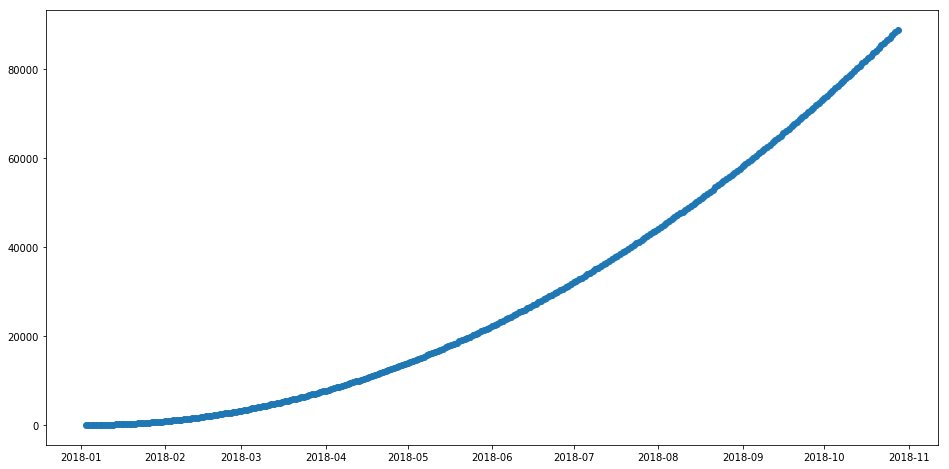

In [18]:
import datetime
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
date_start = datetime.datetime( 2018, 1, 3)
date_end = datetime.datetime( 2018, 10, 29)
delta_date = datetime.timedelta(days=1)
dates = drange(date_start, date_end, delta_date)

ys = np.arange( len(dates) )

fig, ax = plt.subplots(figsize=(16,8))


ax.plot_date(dates, ys*ys)

ax.xaxis.set_major_formatter( DateFormatter('%Y-%m') )

plt.show()

In [19]:
import seaborn as sns

/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
